# SciSketch - The AI Powered BioRender

In [1]:
pip install tqdm dask cairosvg pillow matplotlib easyocr scikit-learn opencv-python-headless pandas distributed torch torchvision torchaudio pyspark setuptools

  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached CairoSVG-2.7.1-py3-none-any.whl.metadata (2.7 kB)
  Using cached pillow-10.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached matplotlib-3.9.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached easyocr-1.7.1-py3-none-any.whl.metadata (11 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached pandas-2.2.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached torch-2.3.0-cp312-none-macosx_11_0_arm64.whl.metadata (26 kB)
  Using cached torchvision-0.18.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.6 kB)
  Using cached torchaudio-2.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pyspark-3.5.1-py2.py3-none-any.whl
  Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached cloudpickle-3.0.0-py3-none-any

In [23]:
import pandas as pd

df = pd.read_csv('Final-csv.csv')

df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['Link', 'Link_to_img'], inplace=True)

def process_image_path(image_path):
    base_path = '/Users/stevensu/Desktop/SciSketch-Summer'
    # Find the position of '/Images'
    position = image_path.find('/Images')
    if position != -1:
        return base_path + image_path[position:]
    else:
        return base_path + image_path  # Concatenate base_path even if '/Images' is not found

df['saved_image_path'] = df['saved_image_path'].apply(process_image_path)

# Print the processed dataframe



,Abstract,saved_image_path
0,Tumor immune surveillance and cancer immunothe...,/Users/stevensu/Desktop/SciSketch-Summer/Image...
1,MicroRNAs (miRNAs) regulate gene expression th...,/Users/stevensu/Desktop/SciSketch-Summer/Image...
2,The mechanisms by which ubiquitin ligases are ...,/Users/stevensu/Desktop/SciSketch-Summer/Image...
3,The maintenance of H3K9 and DNA methylation at...,/Users/stevensu/Desktop/SciSketch-Summer/Image...
4,We report that diffuse large B cell lymphoma (...,/Users/stevensu/Desktop/SciSketch-Summer/Image...


In [1]:
import easyocr
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import torch
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType, StructType, StructField, IntegerType
import os

# Define the function to process images
def process_image(image_path):
    # Load the main image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from path {image_path}")
        return None

    original_image = image.copy()

    # Initialize the EasyOCR reader with GPU support if available
    if torch.backends.mps.is_available():
        reader = easyocr.Reader(['en'], gpu=True)  # Use MPS (Metal Performance Shaders) backend
    else:
        reader = easyocr.Reader(['en'], gpu=False)

    # Perform OCR on the image
    results = reader.readtext(original_image)

    # Extract the bounding box coordinates and text
    boxes = [item[0] for item in results]
    texts = [item[1] for item in results]

    # Draw bounding boxes and texts on the image
    for box, text in zip(boxes, texts):
        # Draw the bounding box
        top_left = tuple(map(int, box[0]))
        bottom_right = tuple(map(int, box[2]))
        cv2.rectangle(original_image, top_left, bottom_right, (0, 255, 0), 2)

        # Put the OCR text near the bounding box
        cv2.putText(original_image, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Calculate the center of each bounding box
    centers = np.array([[(box[0][0] + box[2][0]) / 2, (box[0][1] + box[2][1]) / 2] for box in boxes])

    # Cluster the bounding boxes using DBSCAN
    clustering = DBSCAN(eps=70, min_samples=1).fit(centers)

    # Group the boxes and texts by cluster
    clusters = {}
    for idx, label in enumerate(clustering.labels_):
        if label not in clusters:
            clusters[label] = {
                'boxes': [],
                'texts': []
            }
        clusters[label]['boxes'].append(boxes[idx])
        clusters[label]['texts'].append(texts[idx])

    text_annotations = []
    for cluster in clusters.values():
        combined_text = ' '.join(cluster['texts'])

        # Get the bounding box of the cluster
        x_min = min([box[0][0] for box in cluster['boxes']])
        y_min = min([box[0][1] for box in cluster['boxes']])
        x_max = max([box[2][0] for box in cluster['boxes']])
        y_max = max([box[2][1] for box in cluster['boxes']])

        # Convert to integers
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

        # Append to the list of text annotations
        text_annotations.append({
            'text': combined_text,w
            'coordinates': [x_min, y_min, x_max, y_max]
        })
        
            # Display the image with bounding boxes and OCR results
    cv2.imshow('Processed Image', original_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


    return text_annotations

# Example usage
image_path = '/Users/stevensu/Desktop/SciSketch-Summer/Images/1-s2.0-S1097276511007131-fx1_lrg.jpg'
annotations = process_image(image_path)
print(annotations)

In [27]:
df_test = df.head(4)

df_test['processed_image'] = df_test['saved_image_path'].apply(process_image)

df_test.head()


/var/folders/_x/wyfrzx6n449_pdz7fclsbkjh0000gn/T/ipykernel_6895/2666900052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['processed_image'] = df_test['saved_image_path'].apply(process_image)


,Abstract,saved_image_path,processed_image
0,Tumor immune surveillance and cancer immunothe...,/Users/stevensu/Desktop/SciSketch-Summer/Image...,"[{'text': 'Ecdysone', 'coordinates': [165, 87,..."
1,MicroRNAs (miRNAs) regulate gene expression th...,/Users/stevensu/Desktop/SciSketch-Summer/Image...,"[{'text': 'IL-1O', 'coordinates': [1080, 0, 13..."
2,The mechanisms by which ubiquitin ligases are ...,/Users/stevensu/Desktop/SciSketch-Summer/Image...,"[{'text': 'AUG', 'coordinates': [529, 180, 626..."
3,The maintenance of H3K9 and DNA methylation at...,/Users/stevensu/Desktop/SciSketch-Summer/Image...,"[{'text': 'A', 'coordinates': [0, 0, 55, 59]},..."


In [3]:
import easyocr
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import torch
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType, StructType, StructField, IntegerType
import os

# Define the function to process images
def process_image(image_path):
    # Load the main image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from path {image_path}")
        return None

    original_image = image.copy()

    # Initialize the EasyOCR reader with GPU support if available
    if torch.backends.mps.is_available():
        reader = easyocr.Reader(['en'], gpu=True)  # Use MPS (Metal Performance Shaders) backend
    else:
        reader = easyocr.Reader(['en'], gpu=False)

    # Perform OCR on the image
    results = reader.readtext(original_image)

    # Extract the bounding box coordinates and text
    boxes = [item[0] for item in results]
    texts = [item[1] for item in results]

    # Calculate the center of each bounding box
    centers = np.array([[(box[0][0] + box[2][0]) / 2, (box[0][1] + box[2][1]) / 2] for box in boxes])

    # Cluster the bounding boxes using DBSCAN
    clustering = DBSCAN(eps=70, min_samples=1).fit(centers)

    # Group the boxes and texts by cluster
    clusters = {}
    for idx, label in enumerate(clustering.labels_):
        if label not in clusters:
            clusters[label] = {
                'boxes': [],
                'texts': []
            }
        clusters[label]['boxes'].append(boxes[idx])
        clusters[label]['texts'].append(texts[idx])

    text_annotations = []
    for cluster in clusters.values():
        combined_text = ' '.join(cluster['texts'])

        # Get the bounding box of the cluster
        x_min = min([box[0][0] for box in cluster['boxes']])
        y_min = min([box[0][1] for box in cluster['boxes']])
        x_max = max([box[2][0] for box in cluster['boxes']])
        y_max = max([box[2][1] for box in cluster['boxes']])

        # Convert to integers
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

        # Append to the list of text annotations
        text_annotations.append({
            'text': combined_text,
            'coordinates': [x_min, y_min, x_max, y_max]
        })

    return text_annotations

# # Define the UDF to be used in PySpark
# @udf(returnType=ArrayType(StructType([
#     StructField("text", StringType(), True),
#     StructField("coordinates", ArrayType(IntegerType()), True)
# ])))

# def process_image_udf(image_path):
#     return process_image(image_path)

# # Initialize Spark session
# spark = SparkSession.builder.appName("ImageProcessingApp").getOrCreate()

# # Define schema for DataFrame
# schema = StructType([
#     StructField("Abstract", StringType(), True),
#     StructField("saved_image_path", StringType(), True)
# ])

# # Convert the processed Pandas DataFrame to a Spark DataFrame
# sdf = spark.createDataFrame(df, schema=schema)

# # Repartition the DataFrame
# sdf = sdf.repartition(40)  # Adjust the number based on your system's capacity

# # Apply the UDF to process images
# sdf = sdf.withColumn("text_annotations", process_image_udf(sdf["saved_image_path"]))

# # Select the relevant columns
# sdf = sdf.select("Abstract", "text_annotations")

# # Convert to JSON format and save the output
# sdf.write.json("/Users/stevensu/Desktop/SciSketch-Dataset/processed_data.json")

# # Stop Spark session
# spark.stop()

[{'text': 'Crosslink RNA to protein', 'coordinates': [182, 32, 393, 109]}, {'text': '228', 'coordinates': [792, 38, 848, 70]}, {'text': 'eCLIPs', 'coordinates': [858, 37, 964, 69]}, {'text': 'CDS', 'coordinates': [688, 92, 740, 122]}, {'text': "5' UTR", 'coordinates': [580, 134, 670, 164]}, {'text': 'Immunoprecipitate RNA-protein complexes', 'coordinates': [182, 140, 521, 217]}, {'text': 'RNA', 'coordinates': [702, 174, 754, 202]}, {'text': 'Splice', 'coordinates': [798, 190, 892, 222]}, {'text': 'site', 'coordinates': [900, 190, 964, 218]}, {'text': 'Sequence and align reads', 'coordinates': [182, 244, 393, 323]}, {'text': 'tRNA/ snRNA', 'coordinates': [618, 264, 770, 294]}, {'text': 'SnoRNA', 'coordinates': [508, 280, 598, 306]}, {'text': 'MtRNA', 'coordinates': [732, 302, 814, 332]}, {'text': "3' UTR", 'coordinates': [876, 310, 966, 340]}, {'text': 'Call RNA elements enriched over input', 'coordinates': [183, 353, 459, 431]}, {'text': 'Intron', 'coordinates': [796, 356, 890, 382]}, 

In [3]:
import easyocr
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import torch

def process_image(image_path):
    # Load the main image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from path {image_path}")
        return None

    original_image = image.copy()

    # Initialize the EasyOCR reader with GPU support if available
    if torch.backends.mps.is_available():
        reader = easyocr.Reader(['en'], gpu=True)  # Use MPS (Metal Performance Shaders) backend
    else:
        reader = easyocr.Reader(['en'], gpu=False)

    # Perform OCR on the image
    results = reader.readtext(original_image)

    # Extract the bounding box coordinates and text
    boxes = [item[0] for item in results]
    texts = [item[1] for item in results]

    # Calculate the center of each bounding box
    centers = np.array([[(box[0][0] + box[2][0]) / 2, (box[0][1] + box[2][1]) / 2] for box in boxes])

    # Cluster the bounding boxes using DBSCAN
    clustering = DBSCAN(eps=50, min_samples=1).fit(centers)

    # Group the boxes and texts by cluster
    clusters = {}
    for idx, label in enumerate(clustering.labels_):
        if label not in clusters:
            clusters[label] = {
                'boxes': [],
                'texts': []
            }
        clusters[label]['boxes'].append(boxes[idx])
        clusters[label]['texts'].append(texts[idx])

    text_annotations = []
    for cluster in clusters.values():
        combined_text = ' '.join(cluster['texts'])

        # Get the bounding box of the cluster
        x_min = min([box[0][0] for box in cluster['boxes']])
        y_min = min([box[0][1] for box in cluster['boxes']])
        x_max = max([box[2][0] for box in cluster['boxes']])
        y_max = max([box[2][1] for box in cluster['boxes']])

        # Convert to integers
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

        # Append to the list of text annotations
        text_annotations.append({
            'text': combined_text,
            'coordinates': [x_min, y_min, x_max, y_max]
        })

    return text_annotations

KeyboardInterrupt: 

In [7]:
# from tqdm import tqdm
# import json

# def process_row(row):
#     abstract_text = row['Abstract']
#     image_path = row['saved_image_path']

#     # Process the image and get text annotations
#     text_annotations = process_image(image_path)

#     # Skip if the image could not be processed
#     if text_annotations is None:
#         return None

#     # Create the structured data entry
#     data_entry = {
#         'abstract_text': abstract_text,
#         'text_annotations': text_annotations
#     }

#     return data_entry

# def create_training_data(df):
#     training_data = []
#     for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
#         result = process_row(row)
#         if result is not None:
#             training_data.append(result)
    
#     return training_data

# training_data = create_training_data(df)

# with open('training_data.json', 'w') as f:
#     json.dump(training_data, f, indent=4)

# # Print the structured training data
# for entry in training_data:
#     print(entry)


Processing:   1%|          | 154/24683 [07:52<20:54:35,  3.07s/it]


KeyboardInterrupt: 

In [ ]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prepare_data_for_bert(training_data):
    inputs = []
    text_labels = []
    coord_labels = []

    for entry in training_data:
        abstract_text = entry['abstract_text']
        text_annotations = entry['text_annotations']

        # Tokenize the abstract text
        encoding = tokenizer.encode_plus(
            abstract_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Create labels for text presence and coordinates
        text_label = torch.zeros(input_ids.size())
        coord_label = torch.zeros((input_ids.size(0), 4))

        for annotation in text_annotations:
            text = annotation['text']
            coordinates = annotation['coordinates']

            # Find the start and end tokens of the text in the abstract
            start_idx = abstract_text.find(text)
            if start_idx != -1:
                end_idx = start_idx + len(text) - 1

                # Convert character indices to token indices
                token_start_idx = tokenizer.encode(abstract_text[:start_idx], add_special_tokens=False)
                token_end_idx = tokenizer.encode(abstract_text[:end_idx + 1], add_special_tokens=False)

                token_start_idx = len(token_start_idx)
                token_end_idx = len(token_end_idx)

                text_label[token_start_idx:token_end_idx] = 1  # Mark the presence of text
                coord_label[token_start_idx:token_end_idx, :] = torch.tensor(coordinates)  # Assign coordinates

        inputs.append({
            'input_ids': input_ids,
            'attention_mask': attention_mask
        })
        text_labels.append(text_label)
        coord_labels.append(coord_label)

    return inputs, text_labels, coord_labels

inputs, text_labels, coord_labels = prepare_data_for_bert(training_data)

# Example of how the inputs and labels look
print(inputs[0])
print(text_labels[0])
print(coord_labels[0])


Converting SVG to PNG:   5%|▍         | 112/2437 [00:04<02:10, 17.80it/s]

Error converting /Users/stevensu/Desktop/BioIcons All Images/virus.svg: no element found: line 1, column 0


Converting SVG to PNG:  15%|█▌        | 377/2437 [00:18<00:53, 38.17it/s]

Error converting /Users/stevensu/Desktop/BioIcons All Images/Bacteria2M_spiral.svg: <urlopen error [Errno 2] No such file or directory: '/Users/stevensu/Desktop/BioIcons All Images/7444463B.jpg'>


Converting SVG to PNG:  88%|████████▊ | 2141/2437 [01:41<00:09, 31.82it/s]

Error converting /Users/stevensu/Desktop/BioIcons All Images/Polyomaviridae.svg: no element found: line 1, column 0


Converting SVG to PNG:  90%|████████▉ | 2191/2437 [01:44<00:11, 22.12it/s]

Error converting /Users/stevensu/Desktop/BioIcons All Images/Bacteria2M_coccus.svg: <urlopen error [Errno 2] No such file or directory: '/Users/stevensu/Desktop/BioIcons All Images/DA34F080.jpg'>


Converting SVG to PNG:  97%|█████████▋| 2354/2437 [01:54<00:03, 25.03it/s]

Error converting /Users/stevensu/Desktop/BioIcons All Images/Anterior_view_of_ligaments_of_pelvis.svg: junk after document element: line 3993, column 0


Template Matching: 100%|██████████| 6381/6381 [00:00<00:00, 27773.16it/s]
[ WARN:10@2670.354] global loadsave.cpp:248 findDecoder imread_('/Users/stevensu/Desktop/BioIcons All Images/virus_converted.png'): can't open/read file: check file path/integrity
[ WARN:4@2672.677] global loadsave.cpp:248 findDecoder imread_('/Users/stevensu/Desktop/BioIcons All Images/Anterior_view_of_ligaments_of_pelvis_converted.png'): can't open/read file: check file path/integrity
[ WARN:4@2697.742] global loadsave.cpp:248 findDecoder imread_('/Users/stevensu/Desktop/BioIcons All Images/Polyomaviridae_converted.png'): can't open/read file: check file path/integrity
[ WARN:9@2720.353] global loadsave.cpp:248 findDecoder imread_('/Users/stevensu/Desktop/BioIcons All Images/Bacteria2M_coccus_converted.png'): can't open/read file: check file path/integrity
[ WARN:6@2740.402] global loadsave.cpp:248 findDecoder imread_('/Users/stevensu/Desktop/BioIcons All Images/Bacteria2M_spiral_converted.png'): can't open/rea

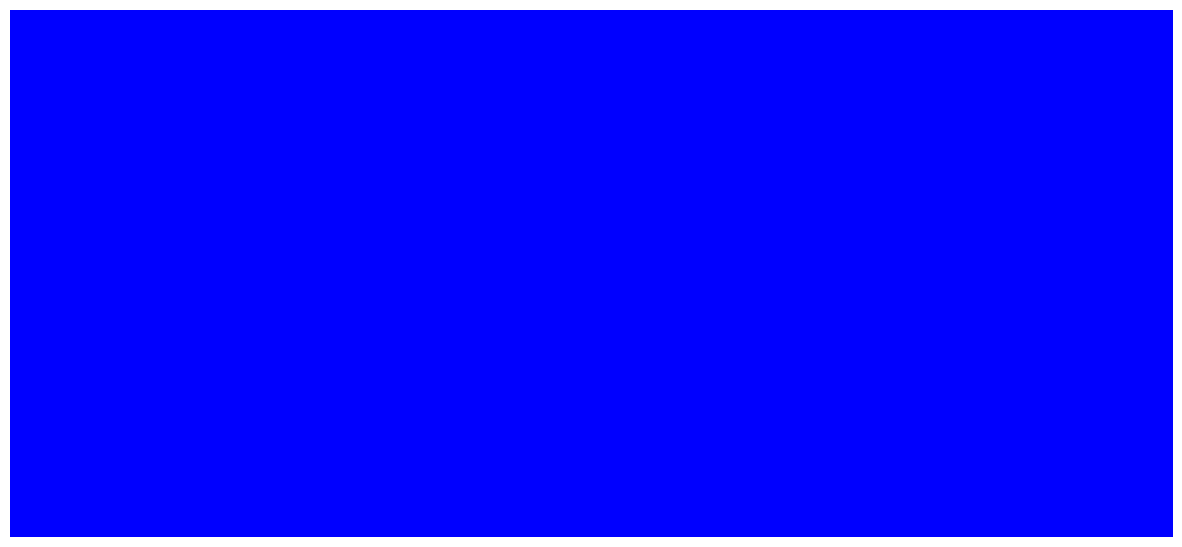

In [8]:
# import cairosvg
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# from tqdm import tqdm
# from dask import delayed, compute

# def convert_svg_to_png(svg_path, output_path):
#     try:
#         cairosvg.svg2png(url=svg_path, write_to=output_path, unsafe=True)
#     except Exception as e:
#         print(f"Error converting {svg_path}: {e}")

# # Load the main image using OpenCV
# image_path = '/Users/stevensu/Desktop/SciSketch-Dataset/Images/1-s2.0-S2667290121000632-gr1_lrg.jpg'  # Update with the correct path if needed
# image = cv2.imread(image_path)

# # Check if the image was loaded successfully
# if image is None:
#     raise FileNotFoundError(f"Cannot open image file: {image_path}")

# original_image = image.copy()

# # List of template image paths
# png_template_paths = glob.glob('/Users/stevensu/Desktop/Servier Medical Art All Images/*.png')
# svg_template_paths = glob.glob('/Users/stevensu/Desktop/BioIcons All Images/*.svg')

# # Convert SVG templates to PNG
# for svg_path in tqdm(svg_template_paths, desc="Converting SVG to PNG"):
#     output_path = svg_path.replace('.svg', '_converted.png')
#     convert_svg_to_png(svg_path, output_path)
#     png_template_paths.append(output_path)

# @delayed
# def match_template(template_path):
#     template = cv2.imread(template_path, 0)
#     if template is None:
#         return []

#     if template.shape[0] > original_image.shape[0] or template.shape[1] > original_image.shape[1]:
#         return []

#     w, h = template.shape[::-1]
#     res = cv2.matchTemplate(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), template, cv2.TM_CCOEFF_NORMED)
#     threshold = 0.8  # Adjust this threshold as needed
#     loc = np.where(res >= threshold)
    
#     boxes = []
#     for pt in zip(*loc[::-1]):
#         box = [pt, (pt[0] + w, pt[1] + h)]
#         boxes.append(box)
#         cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), (255, 0, 0), 2)
    
#     return boxes

# # Template matching with progress bar
# tasks = []
# for template_path in tqdm(png_template_paths, desc="Template Matching"):
#     result = match_template(template_path)
#     tasks.append(result)

# # Compute the results in parallel
# computed_results = compute(*tasks)

# # Collect all detected icon locations
# icon_locations = []
# for loc in computed_results:
#     if loc:
#         icon_locations.extend(loc)

# # Draw bounding boxes for detected icons
# for loc in icon_locations:
#     cv2.rectangle(image, loc[0], loc[1], (255, 0, 0), 2)

# # Display the image with bounding boxes
# plt.figure(figsize=(15, 15))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()
